# FDL 2019 - Floods

Flooding is a destructive, dangerous, and common hazard. Seventy-five percent of all Presidential disaster declarations are associated with flooding [1]. The work in this memorandum focuses specifically on river flooding. The National Oceanic and Atmospheric Administration's (NOAA's) 13 river forecast centers predict river levels at specific river locations up to several days in advance using hydrologic and hydraulic modeling [1,2]. These forecasts can help cities prepare for and respond to river flooding events in the short-term. The Office of Water Prediction also prepares seasonal water forecasts at regional spatial resolution [3]. The work presented here is complementary to these efforts and explores the efficacy of statistical -- instead of hydrological -- models for the prediction and forecasting of river flooding. 

The scope of this project focuses on two measures of flood susceptibility: predicting whether a specific river gage site will flood in a given month, and the time to peak river level during a flood event. These questions were addressed from two perspectives. The first perspective assumes a well-gaged river basin and seeks to forecast the presence of a flood in the forthcoming month, or the time to peak river level for an ongoing rain event. The second perspective addresses the problem of predicting flood susceptibility in poorly gaged or entirely ungaged river basin. For these experiments, no prior river level information is incorporated into the predictive model. The river level data used to train the statistical models is made possible by the extensive network of stream gages maintained by the US Geological Survey (USGS). Once the models are trained, they are used to construct maps of flood susceptibility, and the most important predictors of flood susceptibility from the statistical models are identified. 

The dataset was collected in 6 states over a period of 10 years between 2009.07-2019.07

Load in ml library and required datasets which include:

    -rainfall data from PRISM
    -Landcover information from NLCD
    -Basin Characteristics
    -Threshold Information per site
    -FLASH Flood data

In [1]:
\l ../../fdl2019/ml/ml.q 
\l ../../fdl2019/ml/init.q
\l ../../fdl2019/ml/fresh/notebooks/graphics.q

\l models.q
\l columns_to_include.q
\l load_data.q

### Cleaning up the Dataset 

All site_no should be updated so that they have at least 8 digits. Any with less will be front loaded with 0's. Any nulls or infinity values from the dataset are also deleted

In [2]:
del:{![x;enlist (=;y;z);0b;`symbol$()]}
conv7_fn:{`$$[7=count x;"0",;]x}
precip:update conv7_fn each string each site_no from del[precipall;`ppt;0n]
maxht:update conv7_fn each site_no from del[max_ht_str;`height;neg[0w]]

Add in index column for the warnings table (will be used later for nearest neighbours)

In [3]:
warning:update nn:i from warnings

The PRISM dataset had an id limit of 12 digits, which means that some of the site_no digits were excluded. To not lose datapoints when joining, the remaining digits were added back in


In [4]:
rms:asc ds where 12<count each ds:exec distinct string each site_no from gauges 
names:0!select i by site_no from precip where site_no in `$12#'rms
matchnames:0!select i by lat,long from precip where i in names[`x][20]
lst1:til[26]except 21 22
lst2:til[25]except 20
i1:`$rms[lst1],rms[21 22]
i2:(names[`x]lst2),matchnames`x
precip:{![x;enlist(in;`i;z);0b;enlist[`site_no]!enlist enlist y]}/[precip;i1;i2]

## Feature Engineering

Seasonal Information plays an important role when predicting if an area will flood and how long it will take which is why the sin and cos of each month of the year is calculated

In [5]:
pi:acos -1
precip:update x:cos(lat)*cos(long),y:cos(lat)*sin(long),z:sin(lat) from precip
precip:`date xasc update month:`mm$date from precip
precip:update cos_t:cos 2*pi*(month-1)%11,sin_t:sin 2*pi*(month-1)%11 from precip
stryear:{$[x<2011;6;x<2016;11;16]}each `year$precip[`date]
precip:update year:stryear from precip

The inputs to the features are:

prev_col:
       
       -x  = table that's being updated
       -y  = how many previous values to calculate
       -z  = column to apply the function to 
       -gr = what columns to group by
       -col= new column name
       
window_feat:

       -x  = table that's being updated
       -y  = how many values to calculate
       -z  = column to apply the function to 
       -wh = where to apply the funtion to 
       -gr = what columns to group by
       -col= new column name
       -w  = ? for select statement, ! for update 

In [6]:
prev_col:   {[x;y;z;gr;col]![x;();gr;$[1<count z;raze;]{raze{(enlist`$string[y],"_",string[x],"_",string[z])
             !enlist (xprev;z;x)}[z;y;]each raze x}[y;col]each z]}
window_feat:{[x;y;z;wh;gr;col;w]w[x;wh;gr;$[1<count z;raze;]{raze{(enlist `$string[y],"_",string[x],"_",string[z])
             !enlist (max;(mavg;z;x))}[z;y;]each raze x}[y;col]each z]}

Knowing the upstream values is also an important feature to include into the dataset. The site_numbers are grouped by the first two digits with the remaining digits in ascending order

In [7]:
catch_site:((';#);2;($:;`site_no))
upstr_ppt:prev_col[precip;1;`ppt;`site_no`date!(catch_site;`date);`upstr]
upstr_height:prev_col[maxht;1;`height;`site_no`date!(catch_site;`date);`upstr]

Get the previous x days of rainfall and stream height for each row in the respective datasets

In [8]:
prev_rain:prev_col[upstr_ppt;enlist 1_til 10;`ppt`upstr_ppt_1;(enlist `site_no)!enlist `site_no;`prev]
all_height:prev_col[upstr_height;enlist 1+til 10;`height`upstr_height_1;(enlist `site_no)!enlist `site_no;`prev]

## Joining the characteristics tables 

Join the basin characteristics to the NLCD landcover dataset based on site_no.

In [9]:
stream_char:nlcd ij`site_no xkey basin

## Target Data

### Monthly Target Data

The gage sites are joined to a flood warning level using nearest neighbours

In [10]:
wlatl:raze each warning[`Latitude`Longitude],'gauges[`dec_lat_va`dec_long_v]
tabw:.ml.clust.kd.buildtree[wlatl;2]
gauge_val:count[warning]+til count gauges
nnwarn:.ml.clust.kd.i.nns[;tabw;(count[warning]#0),count[gauges]#1;flip wlatl;`edist]each gauge_val

In [11]:
joins:([site_no:gauges`site_no]nn:nnwarn[;0];ndw:nnwarn[;1])
floodlvl:(maxht ij joins)lj`nn xkey warning
floodlvl[`Action`Moderate`Flood`Major]:"F"$'floodlvl[`Action`Moderate`Flood`Major]

In [12]:
show threshold:0!select first Action,first Flood,first Moderate,first Major,no_Action:count where height>Action
              ,no_Flood:count where height>Flood,no_Mod:count where height>Moderate,no_Major:count where 
               height>Major by site_no,"m"$date from floodlvl

site_no  date    Action Flood Moderate Major no_Action no_Flood no_Mod no_Major
-------------------------------------------------------------------------------
01200000 2009.07 6      9     10       12    0         0        0      0       
01200000 2009.08 6      9     10       12    0         0        0      0       
01200000 2009.09 6      9     10       12    0         0        0      0       
01200000 2009.10 6      9     10       12    0         0        0      0       
01200000 2009.11 6      9     10       12    0         0        0      0       
01200000 2009.12 6      9     10       12    0         0        0      0       
01200000 2010.01 6      9     10       12    0         0        0      0       
01200000 2010.02 6      9     10       12    0         0        0      0       
01200000 2010.03 6      9     10       12    1         0        0      0       
01200000 2010.04 6      9     10       12    0         0        0      0       
01200000 2010.05 6      9     10       1

For the sake of this project, we only want to predict if the "Flood" level was reached or not for a site during a given month. Our target data is a binary label of whether this was reached or not.

Any site that floods more than 28 days per month is omitted from the dataset

In [13]:
threshold:select from threshold where no_Flood<28
threshold[`target]:threshold[`no_Flood]>0

### Time Peak Target Data

After a major rain event, it is important to know how long to will take for the stream to reach peak height.

The FLASH dataset will be used as ground thruth, which highlights how long it will take to reach this peak height, only dates and site numbers used in the rain and height will be extracted.

In [14]:
peak[`delta_peak]:(peak[`peak_time]-peak[`start_time])*24

To predict how long it will take to flood, we have classified this problem as a binary class of whether or not it will take longer than 3 hours. This is important to know how long people have to evacuate from the area when a Flood warning is given.

In [15]:
peak[`target]:peak[`delta_peak]<3.5

## Inputs to the Model

The columns have been divided into three seperate sections:

    -ungaged basin with no perfect forcasts
    -gaged basins with no perfect forcasts
    -gaged basin with perfect forcasts

### Monthly Inputs

When forcasts are provided for each model, knowing how the average rainfall will change over differnet window sizes for each month is a feature that can be added to the dataset.

In [16]:
all_rain:window_feat[prev_rain;enlist 1_til 15;`ppt`upstr_ppt_1;();(`date`site_no)!
         (($;enlist`month;`date);`site_no);`window;!]

The dataset is then broken up into monthly values by taking the first day of each month at a given site

In [17]:
height_data:update date:"m"$date from select from all_height where 1=`dd$date
rain_data:update date:"m"$date from select from all_rain where 1=`dd$date

Join the stream height and rain data based on site number and month, which is then combined with the basin characteristics and Flood threshold dataset by site number and year

In [18]:
height_rain:height_data ij`site_no`date xkey rain_data
all_monthly_data:(height_rain ij`site_no`year xkey stream_char)ij`site_no`date xkey threshold

#### Lagged features

For gaged basins, having knowledge of if an area has flooded in the past or not is also an important feature to extract

In [19]:
all_monthly_data:prev_col[all_monthly_data;enlist 1 12;`target;(enlist `site_no)!enlist `site_no;`lagged]
catch_tgts:0!select site_no,no_Flood,date,cs:count date by site_no from all_monthly_data
all_monthly_data[`lagged_target_all]:raze{count[x]mavg raze x}each?[catch_tgts;();();`no_Flood]

### Time_peak

For the time to peak dataset the day rain and height data is joined to the FLASH dataset based on the site number and date

In [20]:
all_peak_data:((peak ij`date`site_no xkey prev_rain)ij`date`site_no xkey all_height)ij`site_no`year xkey stream_char

#### prev window

To make the times from the stream height dataset consistent with the FLASH dataset, the times have to be changed depending on the time zones

In [21]:
time_zone:raze{dd:x[1];si:x[0];
          select `$first site_no,`$first unk from str where date=first dd,si=`$site_no}each 
          value each 0!select date by distinct site_no from all_peak_data;
all_peak_data:all_peak_data ij`site_no xkey time_zone
change_zone:{$[y=`EDT;neg[04:00]+x;y=`CDT;neg[05:00]+x;neg[06:00]+x]}

In [22]:
all_peak_data[`start_time`peak_time]:change_zone''[;all_peak_data`unk]each all_peak_data[`start_time`delta_peak]

The previous hours before the flood event occurs can show information on how quickly the stream gauge height is moving which can be useful to the model in predicting how long it will take to peak. To do this the 2 days before the event are extracted, and moving averages of different sizes are applied to the stream height dataset

In [23]:
wind_ht_prev:raze{window_feat[str;enlist 2 4 12 48;`height;((within;`date;(,;(+;(-:;2);x[1]);x[1]))
             ;(=;x[0];($;enlist`;`site_no));(within;`datetime;(,;(+;(-:;2);x[2]);x[2])))
             ;0b;`wind_prev;?]}each flip all_peak_data[`site_no`date`start_time]

In [24]:
all_peak_data:all_peak_data,'wind_ht_prev
all_peak_data:del[all_peak_data;`wind_prev_height_2;neg[0w]]

For models that use rain forcasts,knowing what the coming days rainfall will be is also useful to add to the model

In [25]:
rain_pred:raze{window_feat[all_rain;enlist 1_til x;`ppt`upstr_ppt_1;((within;`date;(,;y[1];(+;y[1];x)));
          (=;y[0];`site_no));0b;`fut_window;?]}[3]each flip all_peak_data[`site_no`date]
all_peak_data:all_peak_data,'rain_pred

## Train Test Split

Delete any rows from the dataset that contains a null

In [26]:
del_null:{where not any each null x}
cleaned_monthly:all_monthly_data[del_null all_monthly_data]
cleaned_peak:   all_peak_data[del_null all_peak_data]

In [27]:
fnd_col:{x where x in y}
ungaged_noforcast_basinM: fnd_col[ungaged_noforcast_basin;cols cleaned_monthly]
gaged_basinM:             fnd_col[gaged_basin;cols cleaned_monthly]
perfect_forcastM:         fnd_col[perfect_forcast;cols cleaned_monthly]
ungaged_noforcast_basinP: fnd_col[ungaged_noforcast_basin;cols cleaned_peak]
gaged_basinP:             fnd_col[gaged_basin;cols cleaned_peak]
perfect_forcastP:         fnd_col[perfect_forcast;cols cleaned_peak]

In [28]:
ungage: `M`P!(ungaged_noforcast_basinM;ungaged_noforcast_basinP)
gage:   `M`P!(ungage[`M],gaged_basinM;ungage[`P],gaged_basinP)
forcast:`M`P!(gage[`M],perfect_forcastM;gage[`P],perfect_forcastP)

In [29]:
split_dict:{(!). flip(
  (`ungaged;flip x[ungage[y]]);
  (`gaged;flip x[gage[y]]);
  (`forcast;flip x[forcast[y]]))}

### Monthly 

Split the train and test up by date, so that only past data is contained in the training set. A date was chosen so that 20 percent of the dataset is in the testing set

In [30]:
cutoff:update cutoff:min[date]+floor 0.8*max[date]-min[date] by site_no from cleaned_monthly
XtrainMi:select from cutoff where date<cutoff
ytrainM:exec target from cutoff where date<cutoff
XtestMi:select from cutoff where date>=cutoff
ytestM:exec target from cutoff where date>=cutoff

XtrainM:split_dict[XtrainMi;`M]
XtestM:split_dict[XtestMi;`M]

### Peak

The time to peak data is seperated so that sites do not appear in both the train and test dataset. To distribution the sum of the target per site is shown below. This distribution is seperated into equeally distributed bins and the train and test split is stratified by this split 

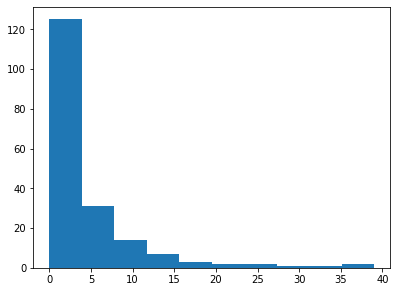

In [31]:
sites:0!select sum target by site_no from cleaned_peak
plt[`:hist][sites`target];
plt[`:show][];

In [32]:
bins:0 5 15 25.0
y_binned:bins bin`float$sites`target
tts:train_test_split[sites[`site_no];sites[`target];`test_size pykw 0.2; `random_state pykw 607;
    `shuffle pykw 1b;`stratify pykw y_binned]`;

In [33]:
cleaned_peak[`split]:`TRAIN
peak_split:update split:`TEST from cleaned_peak where site_no in `$tts[1]

In [34]:
XtrainPi:select from peak_split where split=`TRAIN
ytrainP:exec target from peak_split where split=`TRAIN
XtestPi:select from  peak_split where split=`TEST
ytestP:exec target from peak_split where split=`TEST

XtrainP:split_dict[XtrainPi;`P]
XtestP:split_dict[XtestPi;`P]

## Run Models

Gradient Boosts and Random forests were applied to the train and test datasets and the results were printed as a precision/recall curve. This metric was chosen as getting a balance between precision and recall when predicting floods is pivitol to ensure that all floods are given warnings but also not too many false warnings are given. The inputs to the pr_curve are

    -Xtest
    -ytest
    -dictionary of models that are being used


In [35]:
build_model:{[Xtrain;ytrain;dict]
 rf_clf:      RandomForestClassifier[`n_estimators pykw dict`rf_n;`random_state pykw 0;`class_weight pykw 
            (0 1)!(1;dict`rf_wgt)
              ][`:fit][Xtrain; ytrain];
 xgboost_clf: xgboost_clf: XGBClassifier[`n_estimators pykw dict`xgb_n;`learning_rate pykw dict`xgb_lr;
            `random_state pykw 0;`scale_pos_weight pykw dict`xgb_wgt;`max_depth pykw dict`xgb_maxd
              ][`:fit][np[`:array]Xtrain; ytrain];
 `random_forest`GBDT!(rf_clf;xgboost_clf)}

## Perfect Forcast


Accuracy for random_forest: 0.9454686
Meanclass accuracy for random_forest: 0.9126599


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9471147 0.9971214 0.971475  13201  
1        | 0.8782051 0.271556  0.4148372 1009   
avg/total| 0.9126599 0.6343387 0.6931561 14210  

Accuracy for GBDT: 0.9475795
Meanclass accuracy for GBDT: 0.8049916


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9696878 0.9741686 0.9719231 13201  
1        | 0.6402954 0.6015857 0.6203373 1009   
avg/total| 0.8049916 0.7878772 0.7961302 14210  


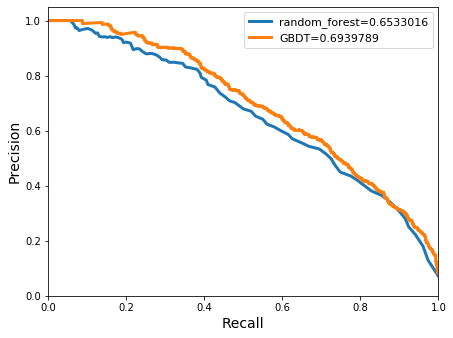

In [36]:
dict:`rf_n`rf_wgt`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;15;100;0.2;15;7)
pr_curve[XtestM`forcast;ytestM;build_model[XtrainM`forcast;ytrainM;dict]]

### Peak Predictions


Accuracy for random_forest: 0.75
Meanclass accuracy for random_forest: 0.7661565


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7489796 0.9657895 0.8436782 380    
1        | 0.7833333 0.2764706 0.4086957 170    
avg/total| 0.7661565 0.62113   0.6261869 550    

Accuracy for GBDT: 0.7735507
Meanclass accuracy for GBDT: 0.7381066


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.8320413 0.8473684 0.8396349 380    
1        | 0.6441718 0.6176471 0.6306306 170    
avg/total| 0.7381066 0.7325077 0.7351328 550    


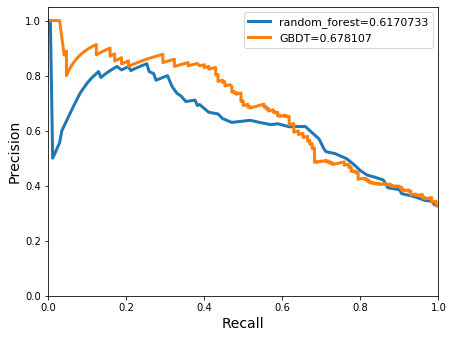

In [37]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;300;0.01;2.5;3)
pr_curve[XtestP`forcast;ytestP;build_model[XtrainP`forcast;ytrainP;dict]]

## Gaged Prediction

### Monthly Predicts


Accuracy for random_forest: 0.9430763
Meanclass accuracy for random_forest: 0.9015436


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9449311 0.9969699 0.9702532 13201  
1        | 0.858156  0.2398414 0.3749032 1009   
avg/total| 0.9015436 0.6184057 0.6725782 14210  

Accuracy for GBDT: 0.9200675
Meanclass accuracy for GBDT: 0.7014841


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9600457 0.9537914 0.9569083 13201  
1        | 0.4429224 0.4806739 0.4610266 1009   
avg/total| 0.7014841 0.7172327 0.7089675 14210  


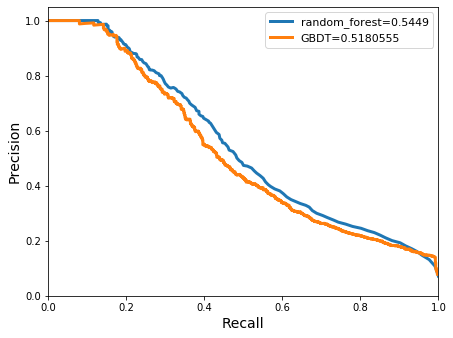

In [38]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(200;15;8;100;.2;15;7)
pr_curve[XtestM`gaged;ytestM;build_model[XtrainM`gaged;ytrainM;dict]]

### Peak Predictions


Accuracy for random_forest: 0.7481884
Meanclass accuracy for random_forest: 0.759479


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7484663 0.9631579 0.8423475 380    
1        | 0.7704918 0.2764706 0.4069264 170    
avg/total| 0.759479  0.6198142 0.624637  550    

Accuracy for GBDT: 0.7717391
Meanclass accuracy for GBDT: 0.7476662


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.793578  0.9105263 0.8480392 380    
1        | 0.7017544 0.4705882 0.5633803 170    
avg/total| 0.7476662 0.6905573 0.7057097 550    


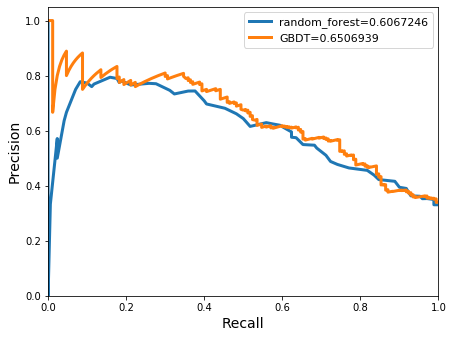

In [39]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;360;0.01;1.5;3)
pr_curve[XtestP`gaged;ytestP;build_model[XtrainP`gaged;ytrainP;dict]]

## Ungaged Prediction 

### Monthly Predictions


Accuracy for random_forest: 0.9391359
Meanclass accuracy for random_forest: 0.8517857


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9428571 0.9949246 0.9681914 13201  
1        | 0.7607143 0.2111001 0.3304888 1009   
avg/total| 0.8517857 0.6030124 0.6493401 14210  

Accuracy for GBDT: 0.9205601
Meanclass accuracy for GBDT: 0.6868068


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9494491 0.9660632 0.9576841 13201  
1        | 0.4241645 0.3270565 0.3693341 1009   
avg/total| 0.6868068 0.6465598 0.6635091 14210  


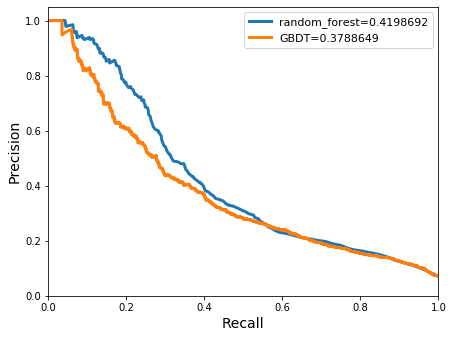

In [40]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(200;1;8;200;.2;15;7)
pr_curve[XtestM`ungaged;ytestM;build_model[XtrainM`ungaged;ytrainM;dict]]

### Peak Prediction


Accuracy for random_forest: 0.7336957
Meanclass accuracy for random_forest: 0.7323232


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7373737 0.9605263 0.8342857 380    
1        | 0.7272727 0.2352941 0.3555556 170    
avg/total| 0.7323232 0.5979102 0.5949206 550    

Accuracy for GBDT: 0.7862319
Meanclass accuracy for GBDT: 0.7638005


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.8098592 0.9078947 0.8560794 380    
1        | 0.7177419 0.5235294 0.6054422 170    
avg/total| 0.7638005 0.7157121 0.7307608 550    


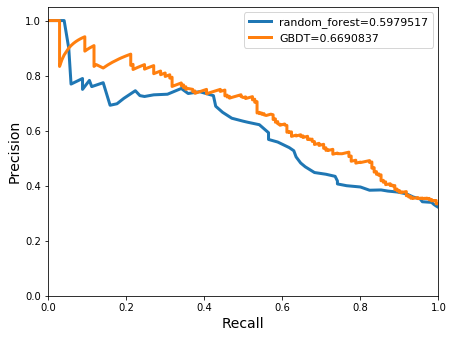

In [41]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;350;.01;1.5;3)
pr_curve[XtestP`ungaged;ytestP;build_model[XtrainP`ungaged;ytrainP;dict]]

### Feature Significance

In [42]:
"The top 15 significant features in predicting the target values for the monthly predicts are:"
string .ml.fresh.significantfeatures[flip forcast[`M]!cleaned_monthly[forcast[`M]];
 cleaned_monthly`target;.ml.fresh.ksigfeat 15]

"The top 15 significant features in predicting the target values for the mont..


"lagged_target_all"
"window_ppt_1"
"window_ppt_2"
"window_ppt_3"
"window_ppt_4"
"window_ppt_5"
"window_ppt_6"
"window_upstr_ppt_1_1"
"window_upstr_ppt_1_2"
"window_upstr_ppt_1_3"
"window_upstr_ppt_1_4"
"lagged_target_12"
"lagged_target_1"
"window_upstr_ppt_1_5"
"window_ppt_7"


In [43]:
"The top 15 significant features in predicting the target values for the time-peak are:"
string .ml.fresh.significantfeatures[flip forcast[`P]!cleaned_peak[forcast[`P]];
 cleaned_peak`target;.ml.fresh.ksigfeat 15]

"The top 15 significant features in predicting the target values for the time..


"WsAreaSqKmRp100"
"WsAreaSqKm"
"wind_prev_height_48"
"prev_upstr_height_1_1"
"wind_prev_height_12"
"prev_height_1"
"prev_height_5"
"WetIndexCat"
"prev_height_4"
"prev_height_7"
"prev_height_6"
"prev_height_2"
"prev_height_8"
"prev_height_3"
"wind_prev_height_4"


## Raster Models

Global Surface Water(GSW) maps the distribution maps the location and temporal distribution of water over the past 3.5 decades globally. This dataset was devoloped in the framework or the Copernicus Programme and was produced by the Landsat satellite. 
The imagery data contains 5 bands:

        -Water Occurence
        -Water Occurence Change Intensity
        -Water Seasonality
        -Annual Water Reoccurance 
        
For the sake of this project we will be looking at 3 bands: Occurence, Seasonality and Reoccurance.

The model will be trained using keras VGG16 model using pre-trained weights from imagenet. Imagenet is a database that contains over 14 million images for more than 20,000 classes of objects. Using pretrained weights allows the model to train faster (if pretrained weights are not used, it could take 100's of hours to train) and saves money and effort.

The GSW imagery is joined with the the tabular data above based on the site number. Two seperate keras models are built for the imagery and tabular data respectively, which is then concatenated together and passed through another neural net. 

In [44]:
VGG16:          .p.import[`keras.applications.vgg16]`:VGG16
pylist:         .p.import[`builtins]`:list
Input:          .p.import[`keras.layers]`:Input
Dense:          .p.import[`keras.layers]`:Dense
Flatten:        .p.import[`keras.layers]`:Flatten
Dropout:        .p.import[`keras.layers]`:Dropout
Model:          .p.import[`keras]`:Model
concatenate:    .p.import[`keras.layers]`:concatenate
sequential:     .p.import[`keras.models]`:Sequential
dense:          .p.import[`keras.layers]`:Dense
normalization:  .p.import[`keras.layers]`:BatchNormalization
pylist:         .p.import[`builtins]`:list
adam:           .p.import[`keras.optimizers]`:Adam
ResNet50:       .p.import[`keras.applications.resnet50]`:ResNet50
rio:            .p.import[`rasterio]
tuple:          .p.import[`builtins]`:tuple
K:              .p.import[`keras]`:backend
earlystop:      .p.import[`keras.callbacks]`:EarlyStopping
km:             .p.import[`keras_metrics]
recall:         km[`:binary_recall]
prec:           km[`:binary_precision]

K[`:set_image_data_format][`channels_first]`

Using TensorFlow backend.


In [ ]:
raster:{rio[`:open][x]}each `$"../../data/raster/",/:string key hsym `$"../../data/raster"
descr:{(x`:descriptions)`}first  raster
raster_read:{x[`:read][]`}each raster

In [ ]:
raster:{(x-ml)%((ml:min l)-max l:raze raze `int$raster_read[x])}each 0 3 4

In [ ]:
raster_tab:flip (`$descr[0 3 4])!raster
rastertab:([] site_no:distinct cleaned_monthly`site_no),'raster_tab
raster_all:(peak_split ij `site_no xkey rastertab)

In [ ]:
input_raster:Input[`shape pykw pylist (3;256;256)]
raster_model:VGG16[`include_top pykw 0b;`input_shape pykw pylist 3 256 256;`weights pykw `imagenet]
raster_model:raster_model[input_raster]
raster_model_1:Flatten[][raster_model]
raster_model_2:Dense[40;`activation pykw `relu;`trainable pykw 0b][raster_model_1]
raster_model_2:Dropout[0.2][raster_model_2]
raster_model_f:Model[`inputs pykw input_raster;`outputs pykw raster_model_2]

In [ ]:
input_tab:Input[`shape pykw enlist 53]
tab_model:dense[40;`activation pykw `relu][input_tab];
tab_model:normalization[][tab_model];
tab_model:dense[40;`activation pykw`relu][tab_model];
tab_model:normalization[][tab_model];
tab_model:dense[40;`activation pykw`relu][tab_model];
tab:model:Dropout[0.02]
tab_model:normalization[][tab_model];
tab_model_f:Model[`inputs pykw input_tab;`outputs pykw tab_model]

In [ ]:
combined:concatenate[((raster_model_f[`:output])`;(tab_model_f[`:output])`)];
model:Dense[216;`activation pykw`relu][combined];
final_m:normalization[][model];
final_m:dense[216;`activation pykw`relu][final_m];
final_m:dense[216;`activation pykw`relu][final_m];
final_m:normalization[][final_m];
final_m:dense[216;`activation pykw`relu][final_m];
final_m:dense[216;`activation pykw`relu][final_m];
final_m:normalization[][final_m];
final_m:dense[1;`activation pykw`relu][model];
final:Model[`inputs pykw ((raster_model_f[`:input])`;(tab_model_f[`:input])`);`outputs pykw final_m]
final[`:compile][`loss pykw`binary_crossentropy;`optimizer pykw `adam;
    `metrics pykw pylist pylist (recall[]`;prec[]`)]; 

In [ ]:
XtrainPi:select from raster_all where split=`TRAIN
ytrainP:exec target from raster_all where split=`TRAIN
XtestPi:select from  raster_all where split=`TEST
ytestP:exec target from raster_all where split=`TEST

XtrainP:split_dict[XtrainPi;`P]
XtestP:split_dict[XtestPi;`P]

In [ ]:
inputs:(flip XtrainPi[`$descr[0 3 4]];flip .ml.stdscaler [flip XtrainP`ungaged])

In [ ]:
epochs:20
batchsz:200
es:earlystop[`monitor pykw `val_loss;`mode pykw `min;`verbose pykw 1;`patience pykw 3];
final[`:fit][`x pykw inputs;`y pykw ytrainP;`batch_size pykw batchsz;
    `verbose pykw 2;`epochs pykw epochs;`validation_split pykw 0.2;
    `callbacks pykw enlist es`];

In [ ]:
nnPred:(raze(final[`:predict](flip XtestPi[`$descr[0 3 4]];flip .ml.stdscaler [flip XtestP`ungaged]))`)>=0.5
-1"\nConfusion matrix for neural network model:\n";
(count where ytestP=nnPred)%count[ytestP]
nnCM:.ml.classreport[ytestP;nnPred]
nnCM

## Conclusion

From the above results we can predict with hight accuracy the .............